<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/IMDB_TextRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install autokeras

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import autokeras as ak

In [10]:
df = pd.read_csv('https://github.com/alankrantas/IMDB-movie-reviews-with-ratings_dataset/raw/main/imdb_sup.csv')
df

,Review,Rating,Sentiment
0,"Kurt Russell's chameleon-like performance, cou...",10,1
1,It was extremely low budget(it some scenes it ...,8,1
2,James Cagney is best known for his tough chara...,8,1
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1
4,One of the last classics of the French New Wav...,10,1
...,...,...,...
49995,(spoiler) it could be the one the worst movie ...,4,0
49996,"So, you've seen the Romero movies, yes? And yo...",1,0
49997,Just listen to the Broadway cast album and to ...,3,0
49998,I have been a fan of the Carpenters for a long...,3,0


# Prepare dataset

In [11]:
x = df['Review'].to_numpy()
y = df['Rating'].to_numpy()
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

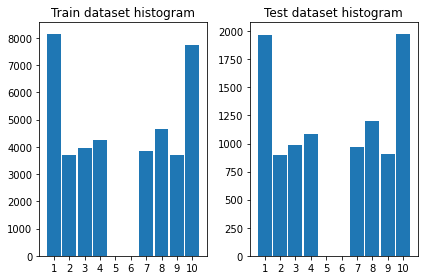

In [12]:
# 資料收集時,自動濾掉評分5.6的評論以更好分類成正負面
fig = plt.figure()
bin = np.arange(11)+1

ax=fig.add_subplot(1,2,1)
ax.set_xticks(bin)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Train dataset histogram')

ax = fig.add_subplot(1, 2, 2)
ax.set_xticks(bin)
plt.hist(y_test, bins=bin-0.5, rwidth=0.9)
ax.set_title('Test dataset histogram')

plt.tight_layout()
plt.show()

# Model
無法用GPU-->除非改Attention or Conv

In [ ]:
# General Search
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
reg = ak.TextRegressor(max_trials=10)
reg.fit(x_train, y_train, callbacks=callbacks)

In [13]:
# Advanced Search
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

# input node
input_node = ak.TextInput()

# output node 
# 使用N-gram類型區塊處理文本,最大token數設為30,000 
output_node = ak.TextBlock(block_type = 'ngram', max_tokens=30000)(input_node)

# regression node
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=3)
reg.fit(x_train, y_train, callbacks=callbacks)


Trial 4 Complete [00h 02m 14s]
val_loss: 3.983071804046631

Best val_loss So Far: 3.778907537460327
Total elapsed time: 00h 08m 41s
INFO:tensorflow:Oracle triggered exit
1250/1250 [==============================] - 18s 14ms/step - loss: 7.9095 - mean_squared_error: 7.9095
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


# Evaluate

In [14]:
reg.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 4.5721 - mean_squared_error: 4.5721


[4.572083473205566, 4.572083473205566]

In [15]:
predicted = reg.predict(x_test[:10]).flatten()

for i in range(10):
  # 預覽每篇評論的內容(前100字)
  print('Review:', x_test[i][:100], '...')
  print('Predict:', predicted[i].round(3))
  print('Real:', y_test[i])
  print('')

1/1 [==============================] - 0s 14ms/step
Review: Having read all of the comments on this film I am still amazed at Fox's reluctance to release a full ...
Predict: 8.554
Real: 9

Review: I like this film a lot. It has a wonderful chemistry between the actors and tells a story that is pr ...
Predict: 7.39
Real: 8

Review: I am a huge fan of Simon Pegg and have watched plenty of his movies until now and none of them have  ...
Predict: 5.818
Real: 7

Review: This was what black society was like before the crack epidemics, gangsta rap, and AIDS that beset th ...
Predict: 7.202
Real: 10

Review: pretty disappointing. i was expecting more of a horror/thriller -- but this seemed to be more of an  ...
Predict: 5.635
Real: 3

Review: As a flagship show, Attack of the Show (AOTS) is endemic of the larger fall of G4 TV; it is a show ( ...
Predict: 4.547
Real: 2

Review: Thomas Capano was not Anne Marie's boss Tom Carper, the Governor was. That is the reason the Feds be ...
Predict: 4.67

# Model Visualization

In [16]:
model = reg.export_model()
model.save('IMDB-TextRegressor_model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 30000)            1         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 32)                960032    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

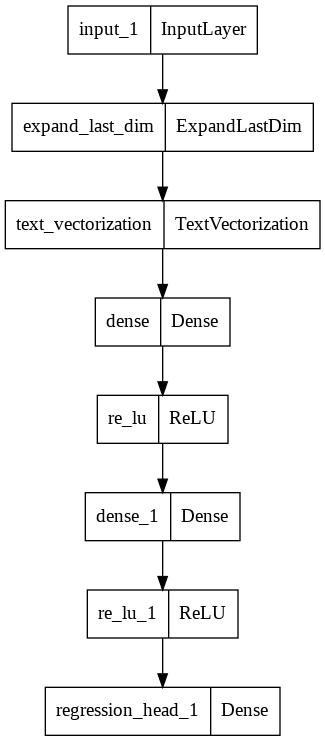

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)